In [1]:
# ---- Parameters ----
SCREEN = "20241118_AWALS35_intermediate_screen_n72"

In [2]:
# Parameters
SCREEN = "20250626_AWALS45_Full_screen_n_96"


In [3]:
from maps.screens import ImageScreenMultiAntibody
from maps.multiantibody.config import TrainConfig, ModelConfig, DataLoaderConfig
import json
import importlib
import sys
import pandas as pd
from pathlib import Path

sys.path.append("/home/kkumbier/maps/")
import maps.multiantibody.data_loaders as data_loaders
import maps.multiantibody.models as models
import maps.multiantibody.training as training
import maps.multiantibody.evaluate as evaluate

# --- Initialize parameters ---
pdir = Path("/home/kkumbier/als/scripts/20250916_pipelines/params")
with open(pdir / "binary-split-train.json", "r") as f:
    train_params = json.load(f)

with open(pdir / "binary-split-test.json", "r") as f:
    test_params = json.load(f)

train_params["screen"] = SCREEN
test_params["screen"] = SCREEN

dataloader_config = DataLoaderConfig()
train_config = TrainConfig()
model_config = ModelConfig()
model_config.n_classes = 2

antibodies = ["FUS/EEA1"]
response_map = {"WT": 0, "FUS": 1}

In [4]:
# Load and process screens for train / test
train_screen = ImageScreenMultiAntibody(train_params)
train_screen.load(antibody=antibodies)

test_screen = ImageScreenMultiAntibody(test_params)
test_screen.load(antibody=antibodies)

print("Processing training set...")
train_screen.preprocess()

print("Processing test set...")
test_screen.preprocess()

assert train_screen.data is not None, "Loading failed"
assert test_screen.data is not None, "Loading failed"

for ab in  antibodies:
    print(f"Marker set: {ab}")
    print(f"Train data: {train_screen.data[ab].shape}")
    print(f"Test data: {test_screen.data[ab].shape}")

Processing training set...


Preprocessing complete
Processing test set...


Preprocessing complete
Marker set: FUS/EEA1
Train data: (17611, 319)
Test data: (16372, 319)


In [5]:
importlib.reload(data_loaders)
create_multiantibody_dataloader = data_loaders.create_multiantibody_dataloader

dataloader_config = DataLoaderConfig()
dataloader_config.batch_size = 8
dataloader_config.n_cells = 250
dataloader_config.response_map = {"Mutations": response_map}

train_dataloader = create_multiantibody_dataloader(
    train_screen,
    **vars(dataloader_config)
)

test_dataloader = create_multiantibody_dataloader(
    test_screen,
    scalers=train_dataloader._get_scalers(),
    **vars(dataloader_config)
)

In [6]:
importlib.reload(training)
importlib.reload(models)
importlib.reload(evaluate)

eval_model = evaluate.eval
train = training.train
MultiAntibodyClassifier = models.MultiAntibodyClassifier

# Initiaize model and train
train_config.n_epochs = 100
train_config.patience = 10
train_config.lr = 5e-3
train_config.use_contrastive_loss = True

model_config.antibody_feature_dims = train_dataloader._get_feature_dims()
model_config.d_model = 16
model_config.n_layers = 1

model_train = MultiAntibodyClassifier(**vars(model_config))
train(model_train, train_dataloader, train_config)

print("Evaluating model...")
test_dataloader.mode = "eval"
df_test, emb_test = eval_model(model_train, test_dataloader)

model_test = MultiAntibodyClassifier(**vars(model_config))
test_dataloader.mode = "train"
train(model_test, test_dataloader, train_config)

print("Evaluating model...")
train_dataloader.mode = "eval"
df_train, emb_train = eval_model(model_test, train_dataloader)

Starting cell-level training...


Cell Epoch 1/100, Overall Loss: 2.6727, Active: 1/1
  FUS/EEA1 - Loss: 0.7487, Acc: 0.5098 


Cell Epoch 2/100, Overall Loss: 2.5194, Active: 1/1
  FUS/EEA1 - Loss: 0.6937, Acc: 0.5615 


Cell Epoch 3/100, Overall Loss: 2.3921, Active: 1/1
  FUS/EEA1 - Loss: 0.6533, Acc: 0.5998 


Cell Epoch 4/100, Overall Loss: 2.3443, Active: 1/1
  FUS/EEA1 - Loss: 0.6427, Acc: 0.6203 


Cell Epoch 5/100, Overall Loss: 2.2870, Active: 1/1
  FUS/EEA1 - Loss: 0.6161, Acc: 0.6485 


Cell Epoch 6/100, Overall Loss: 2.3828, Active: 1/1
  FUS/EEA1 - Loss: 0.6543, Acc: 0.6245 


Cell Epoch 7/100, Overall Loss: 2.2638, Active: 1/1
  FUS/EEA1 - Loss: 0.6136, Acc: 0.6488 


Cell Epoch 8/100, Overall Loss: 2.2458, Active: 1/1
  FUS/EEA1 - Loss: 0.5925, Acc: 0.6838 


Cell Epoch 9/100, Overall Loss: 2.3125, Active: 1/1
  FUS/EEA1 - Loss: 0.6328, Acc: 0.6450 


Cell Epoch 10/100, Overall Loss: 2.1827, Active: 1/1
  FUS/EEA1 - Loss: 0.5842, Acc: 0.6785 


Cell Epoch 11/100, Overall Loss: 2.2133, Active: 1/1
  FUS/EEA1 - Loss: 0.5861, Acc: 0.6858 


Cell Epoch 12/100, Overall Loss: 2.2656, Active: 1/1
  FUS/EEA1 - Loss: 0.6342, Acc: 0.6563 


Cell Epoch 13/100, Overall Loss: 2.3045, Active: 1/1
  FUS/EEA1 - Loss: 0.6357, Acc: 0.6348 


Cell Epoch 14/100, Overall Loss: 2.2948, Active: 1/1
  FUS/EEA1 - Loss: 0.6760, Acc: 0.6073 


Cell Epoch 15/100, Overall Loss: 2.1696, Active: 1/1
  FUS/EEA1 - Loss: 0.5966, Acc: 0.6713 


Cell Epoch 16/100, Overall Loss: 2.1791, Active: 1/1
  FUS/EEA1 - Loss: 0.6056, Acc: 0.6725 


Cell Epoch 17/100, Overall Loss: 2.1883, Active: 1/1
  FUS/EEA1 - Loss: 0.6093, Acc: 0.6550 


Cell Epoch 18/100, Overall Loss: 2.1612, Active: 1/1
  FUS/EEA1 - Loss: 0.5922, Acc: 0.6858 


Cell Epoch 19/100, Overall Loss: 2.1084, Active: 1/1
  FUS/EEA1 - Loss: 0.5867, Acc: 0.6878 


  Freezing FUS/EEA1 encoder at epoch 20
Cell Epoch 20/100, Overall Loss: 2.1421, Active: 0/1
  FUS/EEA1 - Loss: 0.6196, Acc: 0.6425 [FROZEN]
All antibodies frozen - stopping cell training at epoch 20
Starting line-level training...
Unfreezing all antibody encoders for line training...


Line Epoch 1/100, Loss: 0.8430


Line Epoch 2/100, Loss: 0.8978


Line Epoch 3/100, Loss: 0.6912


Line Epoch 4/100, Loss: 0.7469


Line Epoch 5/100, Loss: 0.6373


Line Epoch 6/100, Loss: 0.5960


Line Epoch 7/100, Loss: 0.5800


Line Epoch 8/100, Loss: 0.5733


Line Epoch 9/100, Loss: 0.5487


Line Epoch 10/100, Loss: 0.5495


Line Epoch 11/100, Loss: 0.5825


Line Epoch 12/100, Loss: 0.5672


Line Epoch 13/100, Loss: 0.4514


Line Epoch 14/100, Loss: 0.4779


Line Epoch 15/100, Loss: 0.3855


Line Epoch 16/100, Loss: 0.4862


Line Epoch 17/100, Loss: 0.6006


Line Epoch 18/100, Loss: 0.4750


Line Epoch 19/100, Loss: 0.5418


Line Epoch 20/100, Loss: 0.7284


Line Epoch 21/100, Loss: 0.4170


Line Epoch 22/100, Loss: 0.4537


Line Epoch 23/100, Loss: 0.4123


Line Epoch 24/100, Loss: 0.6123


Line Epoch 25/100, Loss: 0.3756


Line Epoch 26/100, Loss: 0.4330


Line Epoch 27/100, Loss: 0.4125


Line Epoch 28/100, Loss: 0.4517


Line Epoch 29/100, Loss: 0.4063


Line Epoch 30/100, Loss: 0.4378


Line Epoch 31/100, Loss: 0.4171


Line Epoch 32/100, Loss: 0.4464


Line Epoch 33/100, Loss: 0.4524


Line Epoch 34/100, Loss: 0.4851


Line Epoch 35/100, Loss: 0.6353
Early stopping line training at epoch 35
Training completed!
Evaluating model...


Starting cell-level training...


Cell Epoch 1/100, Overall Loss: 2.7680, Active: 1/1
  FUS/EEA1 - Loss: 0.8075, Acc: 0.4808 


Cell Epoch 2/100, Overall Loss: 2.5734, Active: 1/1
  FUS/EEA1 - Loss: 0.7237, Acc: 0.5450 


Cell Epoch 3/100, Overall Loss: 2.5019, Active: 1/1
  FUS/EEA1 - Loss: 0.6828, Acc: 0.5870 


Cell Epoch 4/100, Overall Loss: 2.4403, Active: 1/1
  FUS/EEA1 - Loss: 0.6799, Acc: 0.5928 


Cell Epoch 5/100, Overall Loss: 2.3909, Active: 1/1
  FUS/EEA1 - Loss: 0.6689, Acc: 0.6088 


Cell Epoch 6/100, Overall Loss: 2.3940, Active: 1/1
  FUS/EEA1 - Loss: 0.6661, Acc: 0.6165 


Cell Epoch 7/100, Overall Loss: 2.2673, Active: 1/1
  FUS/EEA1 - Loss: 0.6220, Acc: 0.6540 


Cell Epoch 8/100, Overall Loss: 2.3301, Active: 1/1
  FUS/EEA1 - Loss: 0.6339, Acc: 0.6475 


Cell Epoch 9/100, Overall Loss: 2.2888, Active: 1/1
  FUS/EEA1 - Loss: 0.6397, Acc: 0.6423 


Cell Epoch 10/100, Overall Loss: 2.2842, Active: 1/1
  FUS/EEA1 - Loss: 0.6334, Acc: 0.6350 


Cell Epoch 11/100, Overall Loss: 2.3522, Active: 1/1
  FUS/EEA1 - Loss: 0.6812, Acc: 0.5923 


Cell Epoch 12/100, Overall Loss: 2.2366, Active: 1/1
  FUS/EEA1 - Loss: 0.6299, Acc: 0.6520 


Cell Epoch 13/100, Overall Loss: 2.2281, Active: 1/1
  FUS/EEA1 - Loss: 0.6510, Acc: 0.6258 


Cell Epoch 14/100, Overall Loss: 2.2683, Active: 1/1
  FUS/EEA1 - Loss: 0.6509, Acc: 0.6363 


Cell Epoch 15/100, Overall Loss: 2.1761, Active: 1/1
  FUS/EEA1 - Loss: 0.6052, Acc: 0.6810 


Cell Epoch 16/100, Overall Loss: 2.2457, Active: 1/1
  FUS/EEA1 - Loss: 0.6152, Acc: 0.6668 


Cell Epoch 17/100, Overall Loss: 2.2126, Active: 1/1
  FUS/EEA1 - Loss: 0.6194, Acc: 0.6545 


Cell Epoch 18/100, Overall Loss: 2.2126, Active: 1/1
  FUS/EEA1 - Loss: 0.6345, Acc: 0.6368 


Cell Epoch 19/100, Overall Loss: 2.1403, Active: 1/1
  FUS/EEA1 - Loss: 0.5922, Acc: 0.6878 


Cell Epoch 20/100, Overall Loss: 2.1155, Active: 1/1
  FUS/EEA1 - Loss: 0.6218, Acc: 0.6590 


Cell Epoch 21/100, Overall Loss: 2.1145, Active: 1/1
  FUS/EEA1 - Loss: 0.6001, Acc: 0.6815 


Cell Epoch 22/100, Overall Loss: 2.1586, Active: 1/1
  FUS/EEA1 - Loss: 0.6222, Acc: 0.6638 


Cell Epoch 23/100, Overall Loss: 2.1648, Active: 1/1
  FUS/EEA1 - Loss: 0.5978, Acc: 0.6790 


Cell Epoch 24/100, Overall Loss: 2.1850, Active: 1/1
  FUS/EEA1 - Loss: 0.6136, Acc: 0.6753 


Cell Epoch 25/100, Overall Loss: 2.1475, Active: 1/1
  FUS/EEA1 - Loss: 0.6236, Acc: 0.6498 


Cell Epoch 26/100, Overall Loss: 2.1259, Active: 1/1
  FUS/EEA1 - Loss: 0.5924, Acc: 0.6993 


Cell Epoch 27/100, Overall Loss: 2.1421, Active: 1/1
  FUS/EEA1 - Loss: 0.6000, Acc: 0.6818 


Cell Epoch 28/100, Overall Loss: 2.1865, Active: 1/1
  FUS/EEA1 - Loss: 0.6485, Acc: 0.6298 


Cell Epoch 29/100, Overall Loss: 2.0880, Active: 1/1
  FUS/EEA1 - Loss: 0.5843, Acc: 0.6970 


Cell Epoch 30/100, Overall Loss: 2.1606, Active: 1/1
  FUS/EEA1 - Loss: 0.6141, Acc: 0.6660 


Cell Epoch 31/100, Overall Loss: 2.1114, Active: 1/1
  FUS/EEA1 - Loss: 0.5950, Acc: 0.6928 


Cell Epoch 32/100, Overall Loss: 2.0995, Active: 1/1
  FUS/EEA1 - Loss: 0.5970, Acc: 0.6823 


Cell Epoch 33/100, Overall Loss: 2.0990, Active: 1/1
  FUS/EEA1 - Loss: 0.6088, Acc: 0.6703 


Cell Epoch 34/100, Overall Loss: 2.1102, Active: 1/1
  FUS/EEA1 - Loss: 0.6012, Acc: 0.6793 


Cell Epoch 35/100, Overall Loss: 2.1489, Active: 1/1
  FUS/EEA1 - Loss: 0.5986, Acc: 0.6863 


Cell Epoch 36/100, Overall Loss: 2.1079, Active: 1/1
  FUS/EEA1 - Loss: 0.6005, Acc: 0.6825 


Cell Epoch 37/100, Overall Loss: 2.1298, Active: 1/1
  FUS/EEA1 - Loss: 0.6032, Acc: 0.6755 


Cell Epoch 38/100, Overall Loss: 2.2312, Active: 1/1
  FUS/EEA1 - Loss: 0.6775, Acc: 0.6150 


  Freezing FUS/EEA1 encoder at epoch 39
Cell Epoch 39/100, Overall Loss: 2.0973, Active: 0/1
  FUS/EEA1 - Loss: 0.5991, Acc: 0.6825 [FROZEN]
All antibodies frozen - stopping cell training at epoch 39
Starting line-level training...
Unfreezing all antibody encoders for line training...


Line Epoch 1/100, Loss: 0.7555


Line Epoch 2/100, Loss: 0.7024


Line Epoch 3/100, Loss: 0.6830


Line Epoch 4/100, Loss: 0.5844


Line Epoch 5/100, Loss: 0.5787


Line Epoch 6/100, Loss: 0.5405


Line Epoch 7/100, Loss: 0.4943


Line Epoch 8/100, Loss: 0.4784


Line Epoch 9/100, Loss: 0.4294


Line Epoch 10/100, Loss: 0.4180


Line Epoch 11/100, Loss: 0.4654


Line Epoch 12/100, Loss: 0.3870


Line Epoch 13/100, Loss: 0.4660


Line Epoch 14/100, Loss: 0.4027


Line Epoch 15/100, Loss: 0.4414


Line Epoch 16/100, Loss: 0.4204


Line Epoch 17/100, Loss: 0.4116


Line Epoch 18/100, Loss: 0.3385


Line Epoch 19/100, Loss: 0.4415


Line Epoch 20/100, Loss: 0.3643


Line Epoch 21/100, Loss: 0.4430


Line Epoch 22/100, Loss: 0.6616


Line Epoch 23/100, Loss: 0.4384


Line Epoch 24/100, Loss: 0.4596


Line Epoch 25/100, Loss: 0.3903


Line Epoch 26/100, Loss: 0.4657


Line Epoch 27/100, Loss: 0.3436


Line Epoch 28/100, Loss: 0.3852
Early stopping line training at epoch 28
Training completed!
Evaluating model...


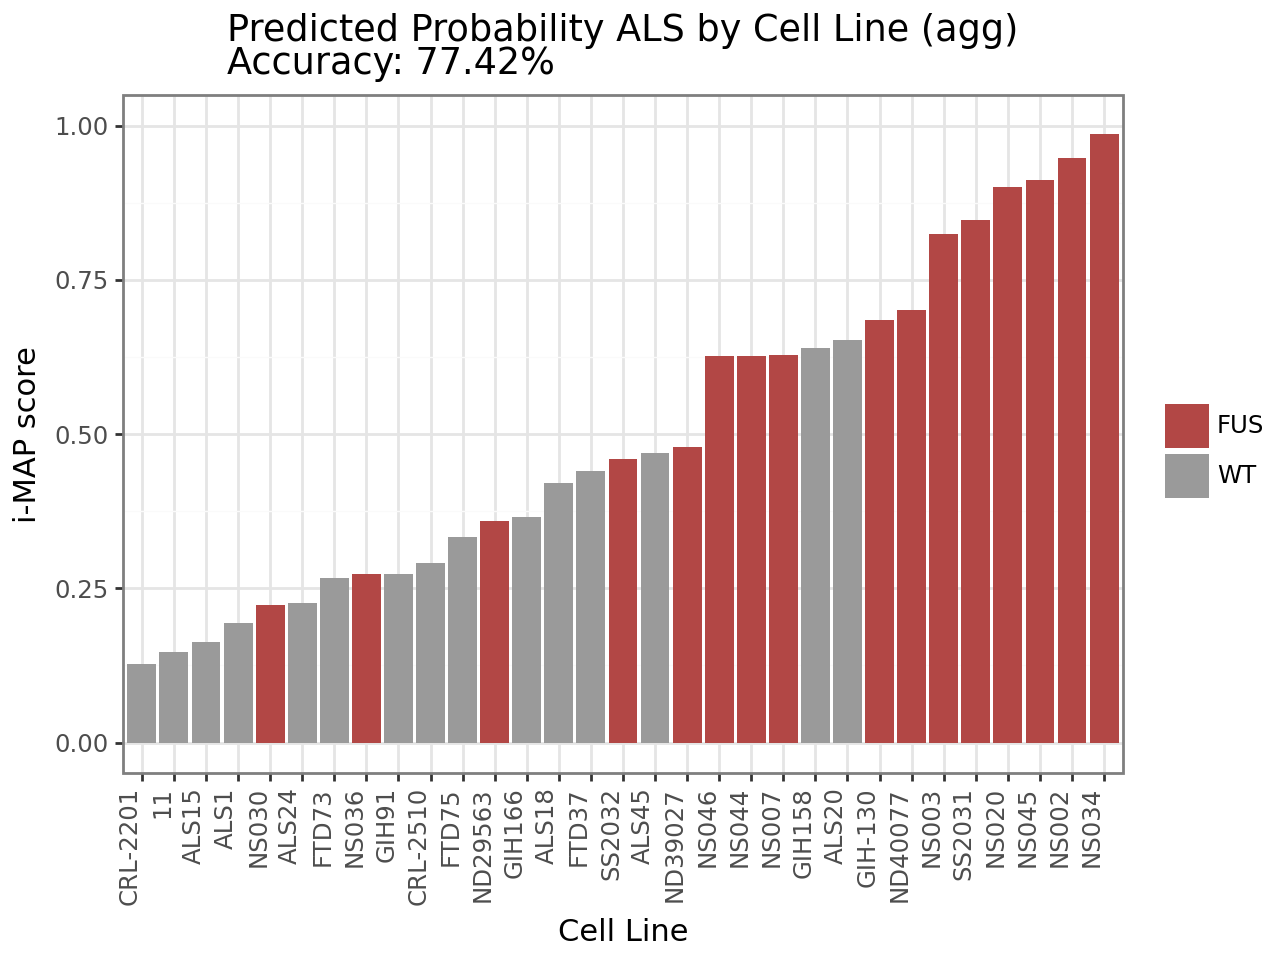

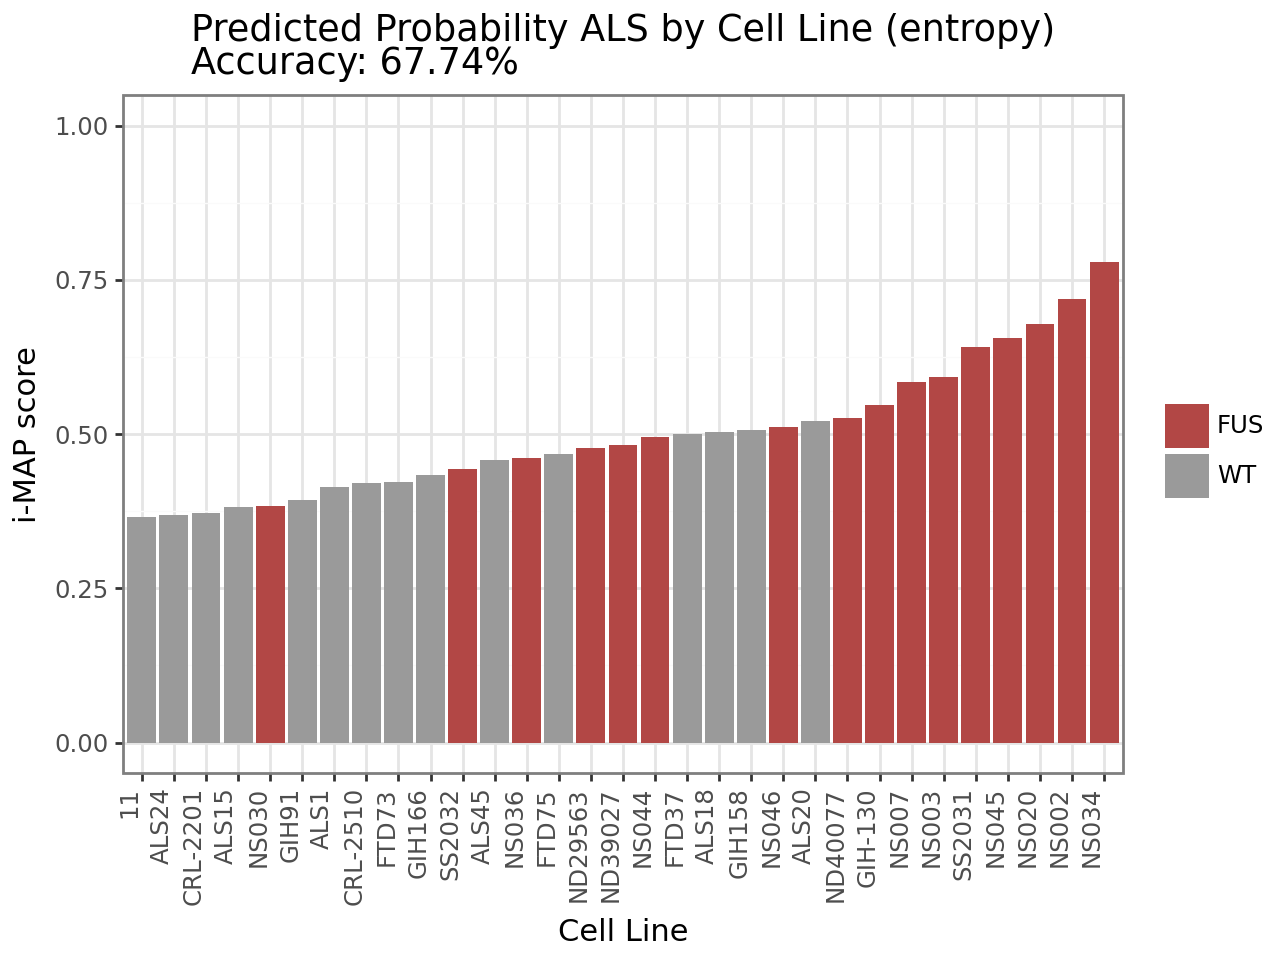

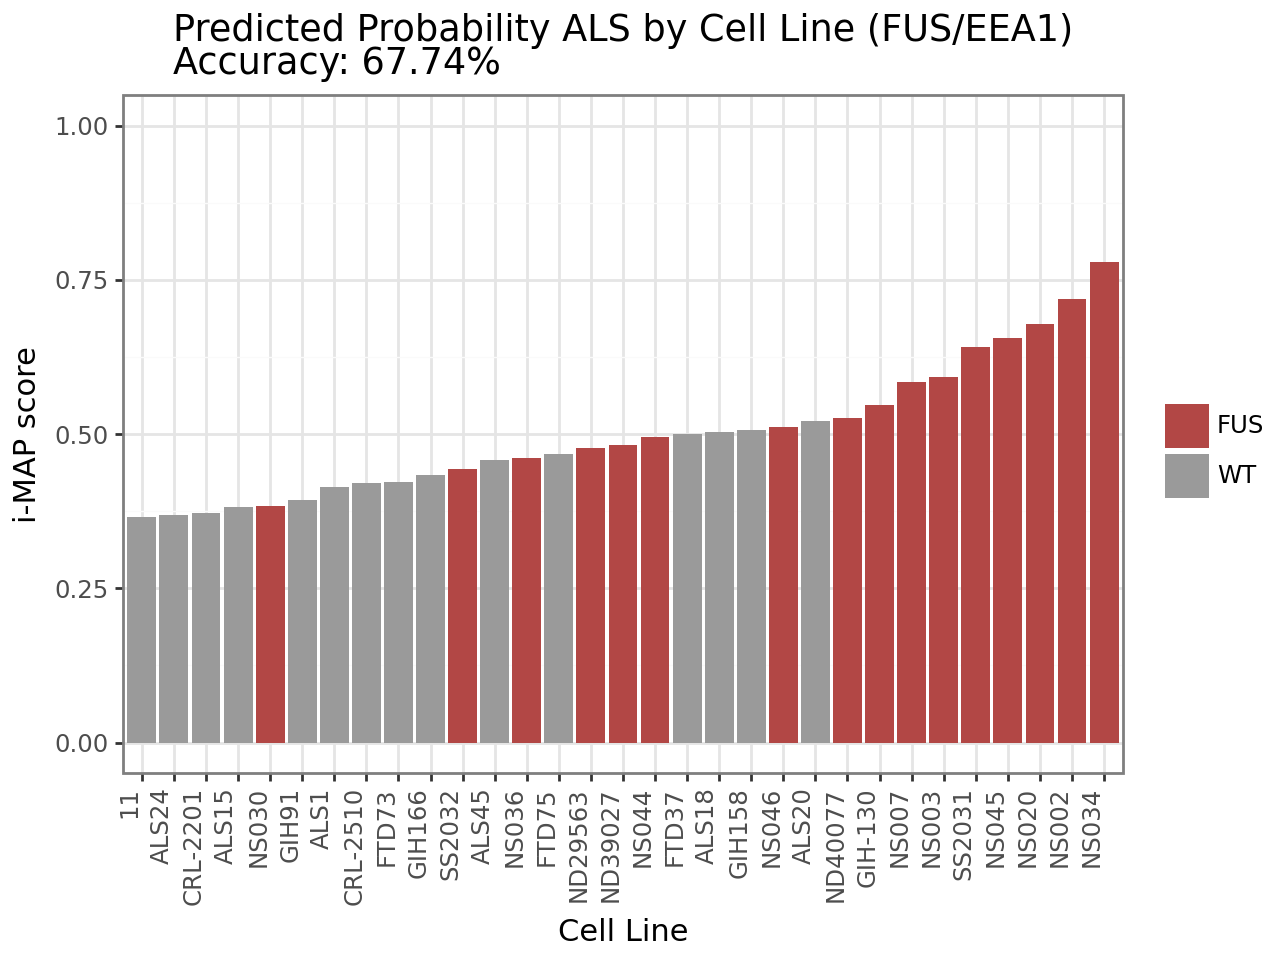

In [7]:
from IPython.display import display
from maps.figures import PALETTE

from plotnine import (
    ggplot, aes, geom_bar, theme, element_text, labs, ggtitle, scale_fill_manual, ylim, theme_bw
)

df = pd.concat([df_train, df_test])
groups = ["agg", "entropy"] + antibodies

def plot_preds(df, groups, response_map):
    for g in groups:
        # Sort preds by predicted probability (Class_1) in ascending order
        preds = df.sort_values(by=f'class_1_{g}', ascending=True)
        
        preds['CellLines'] = pd.Categorical(
            preds['CellLines'], categories=preds['CellLines'], ordered=True
        )
        
        # Compute prediction accuracy for current group
        pred_labels = (preds[f'class_1_{g}'] > 0.5)
        accuracy = (pred_labels == preds["True"]).mean()
        preds["True"] = preds["True"].map({0: "WT", 1: "FUS"})
        
        p = (
            ggplot(preds, aes(x='CellLines', y=f'class_1_{g}', fill='True')) +
            geom_bar(stat='identity') +
            theme_bw() +
            theme(axis_text_x=element_text(rotation=90, hjust=1)) +
            labs(x='Cell Line', y='i-MAP score', fill="") +
            ggtitle(
                f"Predicted Probability ALS by Cell Line ({g})\nAccuracy: {accuracy:.2%}") +
            scale_fill_manual(values=PALETTE) +
            ylim(0, 1)
        )
        display(p)
        
plot_preds(df, groups, response_map)

In [8]:

screen = train_params["screen"]
df["Mutation"] = df["True"].map({0: "WT", 1: "FUS"})
df = df.rename(columns={"True": "TrueClass"})
df = df.rename(columns={"class_0_agg":"prob_0", "class_1_agg":"prob_1"})
df = df[["prob_0", "prob_1", "CellLines", "TrueClass", "Mutation"]]

out_dir = Path("/home/kkumbier/als/analysis_results")
out_path = out_dir / SCREEN / f"fus_v_wt.csv"
df.to_csv(out_path, index=False)